# Predicting Group Responsible - Initial Model Evaluation

Exploration of models without feature extraction

In [19]:
%matplotlib inline

import ConfigParser
config = ConfigParser.ConfigParser()
config.read('config.ini')

import pandas as pd
import time
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [20]:
from IPython.display import display

gtd = pd.read_csv('gtd_processed_11features.csv', encoding='latin1', low_memory=False)
display(gtd.tail(5))
gtd.shape

,gname,iyear,country,crit1,crit2,crit3,attacktype1,targtype1,targsubtype1,weaptype1,weapsubtype1,ransom
88652,Taliban,2016,4,1,1,0,9,4,27.0,13,0.0,0.0
88653,Taliban,2016,4,1,1,1,3,17,94.0,6,16.0,0.0
88654,Boko Haram,2016,146,1,1,0,9,4,34.0,13,0.0,0.0
88655,Lord's Resistance Army (LRA),2016,229,1,1,1,6,14,75.0,13,0.0,0.0
88656,Sudan Liberation Movement,2016,195,1,1,1,2,14,75.0,5,5.0,0.0


(88657, 12)

Split-out validation dataset

In [21]:
array = gtd.values
seed = 188
X = array[:,1:]
Y = array[:,0]
validation_size = 0.10
X_train, X_validation, Y_train, Y_validation = model_selection.train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [22]:
models = []

models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))

if config.getboolean('Booleans', 'RunPoorPerformingClassifiers') == True:
    models.append(('GNB', GaussianNB())) # GNB: 0.353792% (0.002758) - 9.339 seconds
    models.append(('LDA', LinearDiscriminantAnalysis())) #LDA: 0.285051% (0.004282) - 5.299 seconds

if config.getboolean('Booleans', 'RunRandomForest') == True:
    models.append(('RF', RandomForestClassifier()))

if config.getboolean('Booleans', 'RunSVM') == True:
    models.append(('SVM', SVC(probability=True))) #Too slow for this many samples - O(N^3)
    
results = []
names = []
scoring = 'accuracy'
 
for name, model in models:
    start_time = time.time()
    kfold = model_selection.KFold(n_splits=10, random_state=seed) #ensure same seed so models are directly comparable
    cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f%% (%f) - %s seconds" % (name, cv_results.mean(), cv_results.std(), round((time.time() - start_time),3))
    print(msg)

KNN: 0.663458% (0.005801) - 12.988 seconds
CART: 0.712386% (0.004316) - 17.682 seconds
RF: 0.687358% (0.005338) - 119.1 seconds


### Results: 11 Features, .Tail(10000)
LDA: 0.426000% (0.014946) - 0.313 seconds

KNN: 0.726875% (0.012071) - 0.312 seconds

CART: 0.762125% (0.011389) - 0.371 seconds

RF: 0.716222% (0.016347) - 3.136 seconds

GNB: 0.102750% (0.009401) - 0.763 seconds

SVM: 0.723875% (0.014879) - 342.715 seconds

### Results: 11 Features, All Rows
LDA: 0.302968% (0.005750) - 6.834 seconds

KNN: 0.657032% (0.005536) - 8.244 seconds

CART: 0.706761% (0.004214) - 12.792 seconds

GNB: 0.064843% (0.003521) - 17.24 seconds

RF: 0.684877% (0.004442) - 112.637 seconds

Compare Algorithms

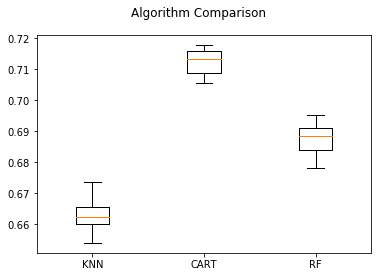

In [23]:
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Make predictions on validation dataset

In [24]:
cart = DecisionTreeClassifier()
cart.fit(X_train, Y_train)
predictions = cart.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions)) #TODO: sort out formatting of table - trim name column?

0.719941348974
[[0 0 0 ..., 0 0 0]
 [0 1 0 ..., 0 0 0]
 [0 0 2 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]
                                                                               precision    recall  f1-score   support

                                                                        1 May       0.00      0.00      0.00         1
                                                                   14 K Triad       1.00      1.00      1.00         1
                        16 January Organization for the Liberation of Tripoli       0.50      1.00      0.67         2
                                                                2 April Group       0.50      1.00      0.67         1
                                                  20 December Movement (M-20)       1.00      1.00      1.00         3
                                           23rd of September Communist League       0.60      0.75      0.67         4
                       

/Users/spe_eddy_gonzalez/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/spe_eddy_gonzalez/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
